### 0. Installing & importing libraries

In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from transliterate import translit
import geocoder

import geopandas as gpd
from shapely.geometry import Point, box

In [2]:
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf)

### 1. Traffic accidents data

[Source: Serbian police](https://data.gov.rs/sr/datasets/podatsi-o-saobratshajnim-nezgodama-po-politsijskim-upravama-i-opshtinama/)

##### Getting & merging data

In [ ]:
folder_path = Path("/traffic accidents")
excel_files = list(folder_path.glob("*.xlsx"))

df_list = []

for file in excel_files:
    df = pd.read_excel(file, header=None)
    df_list.append(df)

accidents = pd.concat(df_list, ignore_index=True)

In [ ]:
accidents.head(2)

In [ ]:
accidents.columns = ["id", "police_dept", "municipality", "date_time", "longitude", "latitude", "status", "type", "details"] 

In [ ]:
accidents.head(2)

In [ ]:
accidents.shape

##### Cleaning data

In [ ]:
accidents[['date', 'time']] = accidents['date_time'].str.split(',', expand=True)
accidents['date'] = pd.to_datetime(accidents['date'], format="%d.%m.%Y")
accidents['time'] = pd.to_datetime(accidents['time'], format="%H:%M").dt.time

In [ ]:
accidents['year'] = accidents['date'].dt.year

In [ ]:
accidents.dtypes

In [ ]:
accidents.head(2)

In [ ]:
accidents['status'].unique()

In [ ]:
accidents['status'] = accidents['status'].replace({
    "Sa povredjenim": "injuries",
    "Sa mat.stetom": "material damage",
    "Sa poginulim": "fatalities"
}, regex=False)

In [ ]:
accidents['type'].unique()

In [ ]:
accidents['type'] = accidents['type'].replace({

    'SN SA NAJMANjE DVA VOZILA – BEZ SKRETANjA': 'two vehicles no turning',
    'SN SA NAJMANjE DVA VOZILA – SKRETANjE ILI PRELAZAK': 'two vehicles with turning or crossing',
    'SN SA JEDNIM VOZILOM': 'single vehicle',
    'SN SA PARKIRANIM VOZILIMA': 'parked vehicles',
    'SN SA PEŠACIMA': 'with pedestrians',

}, regex=False)

In [ ]:
accidents['police_dept'] = accidents['police_dept'].str.lower()
accidents['municipality'] = accidents['municipality'].str.lower()

In [ ]:
accidents.head(2)

In [ ]:
accidents.to_csv('accidents_merged.csv', index=False)

##### Data analysis

In [ ]:
accidents = pd.read_csv('accidents_merged.csv')

In [ ]:
accidents.head(2)

In [ ]:
accidents['year'].value_counts().reset_index().sort_values(by='year', ascending=False)

In [ ]:
accidents['municipality'].value_counts(normalize=True).reset_index().head(10)

In [ ]:
accidents['police_dept'].value_counts(normalize=True).reset_index().head(10)

In [ ]:
accidents['status'].value_counts(normalize=True).reset_index().head(10)

In [ ]:
accidents['type'].value_counts(normalize=True).reset_index().head(10)

In [ ]:
accidents['time'].value_counts(normalize=True).reset_index().head(10)

In [ ]:
belgrade_accidents = accidents[accidents.police_dept == 'beograd']
belgrade_accidents.head(2)

In [ ]:
accidents.shape

In [ ]:
belgrade_accidents.shape

In [ ]:
belgrade_accidents.to_csv('belgrade accidents.csv')

### 2. School locations data

[Source: Ministry of Education](https://opendata.mpn.gov.rs)

##### Getting & merging data

In [ ]:
elementary_schools = pd.read_excel('/Users/teodoracurcic/Downloads/Lede/projects/02-traffic near schools/schools/elementary schools.xlsx')
elementary_schools["type"] = "elementary"

high_schools = pd.read_excel('/Users/teodoracurcic/Downloads/Lede/projects/02-traffic near schools/schools/high schools.xlsx')
high_schools["type"] = "high"

In [ ]:
elementary_schools.head(1)

In [ ]:
high_schools.head(1)

In [ ]:
schools = pd.concat([elementary_schools, high_schools], ignore_index=True)
schools.head(2)

##### Cleaning data

In [ ]:
schools = schools.map(lambda x: translit(x, 'sr', reversed=True) if isinstance(x, str) else x)
schools.head(2)

In [ ]:
schools.dtypes

In [ ]:
schools = schools.drop(columns=[
    "Skolska godina",
    "Skolska uprava",
    "Povrsina objekta",
    "Broj ucionica",
    "Povrsina ucionica",
    "Broj kabinete",
    "Povrsina kabineta",
    "Broj laboratorija",
    "Povrsina laboratorija",
    "Broj radionica",
    "Povrsina radionica",
    "Broj kuhinja",
    "Povrsina kuhinja",
    "Broj restorana u objektu",
    "Broj fiskulturnih sala",
    "Povrsina fiskulturnih sala",
    "Broj biblioteka",
    "Naziv lokacije ",
    "Naziv objekta",
    "Sediste/radna jedinica",
    "Vrsta Ustanove"
])

In [ ]:
schools = schools.rename(columns={
    "Okrug": "district",
    "Mesto/Grad": "city",
    "Opstina": "municipality",
    "Naziv ustanove": "name",
    "Vrsta Osnivaca": "private_public",
    "Adresa": "address"
})

In [ ]:
schools.shape

In [ ]:
schools.dropna(how='all', inplace=True)

In [ ]:
schools.shape

In [ ]:
schools.dtypes

In [ ]:
schools.head(2)

In [ ]:
schools['district'] = schools['district'].str.lower()
schools['city'] = schools['city'].str.lower()
schools['municipality'] = schools['municipality'].str.lower()

In [ ]:
schools['private_public'].unique()

In [ ]:
schools['private_public'] = schools['private_public'].replace({
    "Privatna ustanova": "private",
    "Javna ustanova": "public",
}, regex=False)

In [ ]:
schools.head(1)

In [ ]:
schools['district'].value_counts()

In [ ]:
belgrade_schools = schools[schools.district == 'grad beograd']
belgrade_schools.shape

In [ ]:
belgrade_schools.to_csv('belgrade schools no coord.csv', index=False)

##### Geocoding

In [ ]:
belgrade_schools = pd.read_csv('belgrade schools no coord.csv')
belgrade_schools.head()

In [ ]:
belgrade_schools['address'].unique()

In [ ]:
belgrade_schools['address'] = belgrade_schools['address'].str.title()

In [ ]:
load_dotenv()

In [ ]:
api_key=os.getenv("api_key")

In [ ]:
latitudes = []
longitudes = []

for idx, row in belgrade_schools.iterrows():
    full_address = row['address']
    g = geocoder.google(full_address, key=api_key)
    if g.latlng:
        lat, lon = g.latlng
    else:
        lat, lon = None, None
    latitudes.append(lat)
    longitudes.append(lon)

belgrade_schools["latitude"] = latitudes
belgrade_schools["longitude"] = longitudes

In [ ]:
belgrade_schools.head()

In [ ]:
belgrade_schools['name'].unique()

In [ ]:
belgrade_schools['name'] = belgrade_schools['name'].str.replace('"', '', regex=False)
belgrade_schools.head(2)

In [ ]:
belgrade_schools.to_csv('belgrade schools.csv', index=False)

### 3. Preparing data for analysis in QGIS & Mapbox

In [ ]:
schools = pd.read_csv('belgrade schools.csv')
accidents = pd.read_csv('belgrade accidents.csv')

In [ ]:
accidents.head(2)

In [ ]:
print(accidents["longitude"].min(), accidents["longitude"].max())
print(accidents["latitude"].min(), accidents["latitude"].max())

In [ ]:
def fix_coord_precisely(val):
    try:
        val = float(val)
    except:
        return None
    if val > 180:
        while val > 180:
            val = val / 10
        return val
    return val

accidents["longitude"] = accidents["longitude"].apply(fix_coord_precisely)
accidents["latitude"] = accidents["latitude"].apply(fix_coord_precisely)

In [ ]:
print(accidents["longitude"].min(), accidents["longitude"].max())
print(accidents["latitude"].min(), accidents["latitude"].max())

In [ ]:
accidents = accidents[
    (accidents["longitude"].between(19, 22)) &
    (accidents["latitude"].between(44, 46))
].copy()

In [ ]:
accidents["geometry"] = accidents.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)
accidents_gdf = gpd.GeoDataFrame(accidents, geometry="geometry", crs="EPSG:4326")

accidents_gdf = accidents_gdf.to_crs(epsg=32634)

In [ ]:
accidents_gdf.to_file("accidents_cleaned.gpkg", driver="GPKG") 

In [ ]:
schools.head(2)

In [ ]:
print(schools["longitude"].min(), schools["longitude"].max())
print(schools["latitude"].min(), schools["latitude"].max())

In [ ]:
schools = schools[
    (schools["longitude"].between(19, 22)) &
    (schools["latitude"].between(44, 46))
].copy()

In [ ]:
schools["geometry"] = schools.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)
schools_gdf = gpd.GeoDataFrame(schools, geometry="geometry", crs="EPSG:4326")

schools_gdf = schools_gdf.to_crs(epsg=32634)

In [ ]:
schools_gdf.to_file("schools.gpkg", driver="GPKG") 

### 4. Data analysis

In [3]:
schools_gdf = gpd.read_file('schools.gpkg')
accidents_gdf = gpd.read_file('accidents_cleaned.gpkg')
traffic_grids = gpd.read_file('schools per zone.geojson')

In [4]:
accidents_gdf.head(1)

,Unnamed: 0,id,police_dept,municipality,date_time,longitude,latitude,status,type,details,date,time,year,geometry
0,0,1309622,beograd,barajevo,"01.01.2021,07:00",20.335314,44.583922,injuries,two vehicles no turning,Najmanje dva vozila koja se kreću u istom smer...,2021-01-01,07:00:00,2021,POINT (447234.794 4936945.946)


In [5]:
schools_gdf.head(1)

,district,city,municipality,name,private_public,address,type,latitude,longitude,geometry
0,grad beograd,beograd (savski venac),savski venac,OŠ Zvezdobrojci,private,"Drinićka 5 A/B, Beograd (Savski Venac), Savski...",elementary,44.790445,20.430742,POINT (454970.514 4959829.523)


In [6]:
traffic_grids.head(1)

,id,left,top,right,bottom,row_index,col_index,accidents_count,danger_level,district_count,city_count,municipality_count,private_public_count,type_count,geometry
0,109,417051.316407,4.938592e+06,417551.316407,4.938092e+06,108,0,0.0,0–1,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((19.96119 44.59371, 19.96121 44..."


#### 4.1. Accidents near schools - 250m

In [7]:
schools_gdf = schools_gdf.rename(columns={'geometry':'geometry_old'})

In [8]:
schools_gdf.head(1)

,district,city,municipality,name,private_public,address,type,latitude,longitude,geometry_old
0,grad beograd,beograd (savski venac),savski venac,OŠ Zvezdobrojci,private,"Drinićka 5 A/B, Beograd (Savski Venac), Savski...",elementary,44.790445,20.430742,POINT (454970.514 4959829.523)


In [9]:
schools_gdf['geometry'] = schools_gdf.geometry_old.buffer(250)
schools_gdf.head(1)

,district,city,municipality,name,private_public,address,type,latitude,longitude,geometry_old,geometry
0,grad beograd,beograd (savski venac),savski venac,OŠ Zvezdobrojci,private,"Drinićka 5 A/B, Beograd (Savski Venac), Savski...",elementary,44.790445,20.430742,POINT (454970.514 4959829.523),"POLYGON ((455220.514 4959829.523, 455219.31 49..."


In [10]:
schools_gdf.geometry.name

'geometry'

In [11]:
accidents_near_schools = gpd.sjoin(accidents_gdf, schools_gdf, how='inner', predicate='within')
accidents_near_schools.head(1)

,Unnamed: 0,id,police_dept,municipality_left,date_time,longitude_left,latitude_left,status,type_left,details,date,time,year,geometry,index_right,district,city,municipality_right,name,private_public,address,type_right,latitude_right,longitude_right,geometry_old
7,7,1312113,beograd,barajevo,"28.01.2021,19:30",20.41669,44.5783,material damage,single vehicle,Nezgode sa učešćem jednog vozila i preprekama ...,2021-01-28,19:30:00,2021,POINT (453690.26 4936272.072),440,grad beograd,barajevo,barajevo,Srednja škola,public,"Svetosavska 4A, Barajevo, Barajevo",high,44.578048,20.416468,POINT (453672.466 4936244.161)


In [12]:
accidents_near_schools.shape

(95570, 25)

In [13]:
accidents_gdf.shape

(143280, 14)

In [14]:
print(f'{((95570/143280)*100):.2f}% accidents happen near school - up untill 250m from the school')

66.70% accidents happen near school - up untill 250m from the school


In [15]:
accidents_near_schools['status'].value_counts(normalize=True)

status
material damage    0.744334
injuries           0.253218
fatalities         0.002448
Name: proportion, dtype: float64

In [16]:
accidents_near_schools['type_right'].value_counts(normalize=True)

type_right
elementary    0.553197
high          0.446803
Name: proportion, dtype: float64

In [17]:
schools_gdf['type'].value_counts(normalize=True)

type
elementary    0.728723
high          0.271277
Name: proportion, dtype: float64

<Axes: ylabel='municipality_right'>

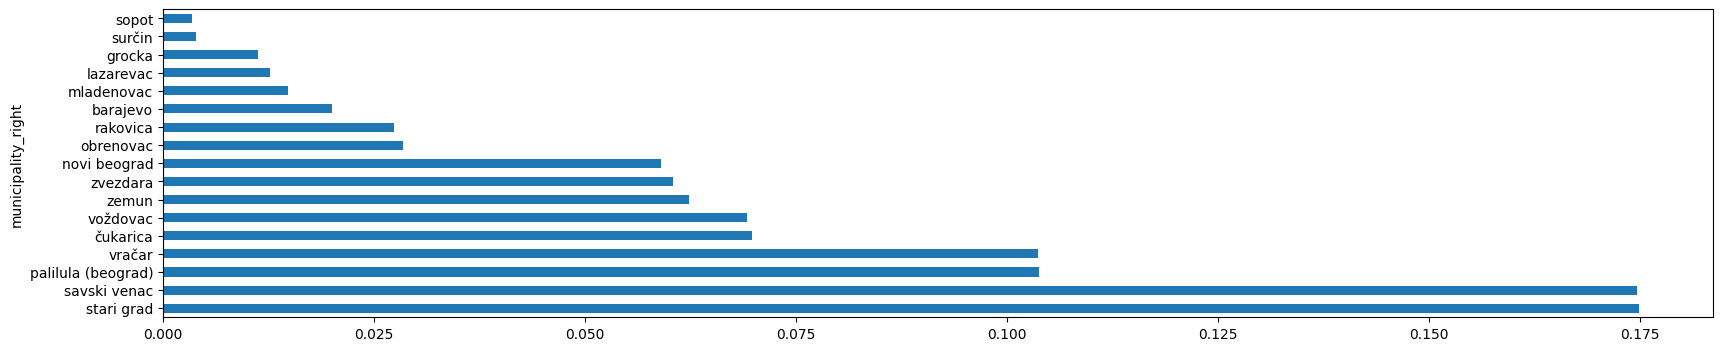

In [18]:
accidents_near_schools['municipality_right'].value_counts(normalize=True).plot(kind='barh', figsize=(20,4))

In [19]:
accidents_near_schools.dtypes

Unnamed: 0               int64
id                       int64
police_dept             object
municipality_left       object
date_time               object
longitude_left         float64
latitude_left          float64
status                  object
type_left               object
details                 object
date                    object
time                    object
year                     int64
geometry              geometry
index_right              int64
district                object
city                    object
municipality_right      object
name                    object
private_public          object
address                 object
type_right              object
latitude_right         float64
longitude_right        float64
geometry_old          geometry
dtype: object

<Axes: ylabel='hour'>

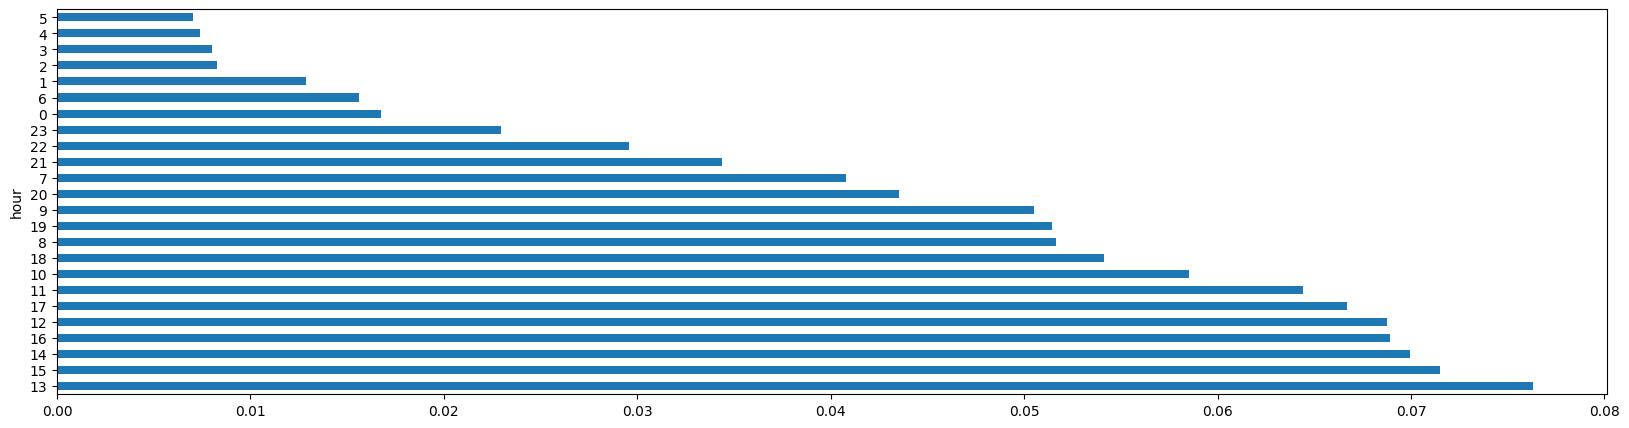

In [20]:
accidents_near_schools['hour'] = pd.to_datetime(accidents_near_schools['time'], format = '%H:%M:%S').dt.hour
accidents_near_schools['hour'].value_counts(normalize=True).plot(kind='barh' , figsize=(20,5))

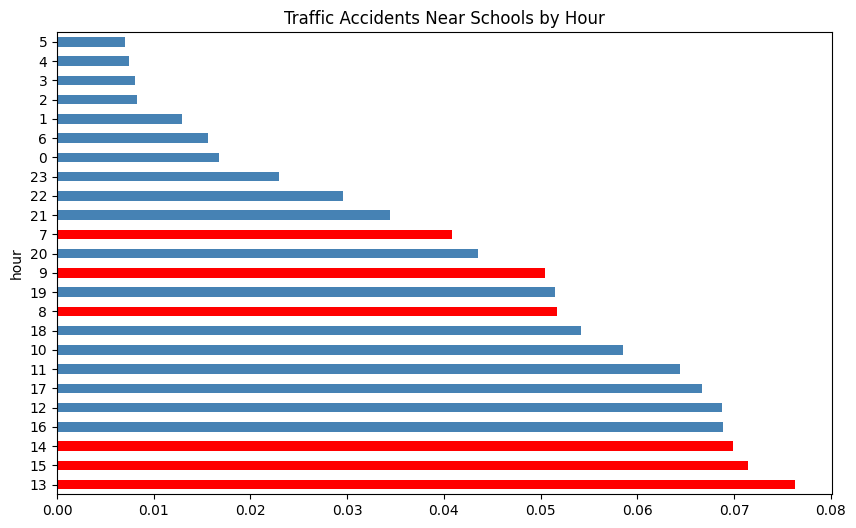

In [21]:
hour_counts = accidents_near_schools['hour'].value_counts(normalize=True)

colors = ['red' if hour in [7,8,9,13,14,15] else 'steelblue' for hour in hour_counts.index]

hour_counts.plot(kind='barh', color=colors, figsize=(10,6))

plt.title("Traffic Accidents Near Schools by Hour")
plt.show()

#### 4.2. Number of schools in "danger zones"

In [22]:
traffic_grids.dtypes

id                         int32
left                     float64
top                      float64
right                    float64
bottom                   float64
row_index                  int32
col_index                  int32
accidents_count          float64
danger_level              object
district_count           float64
city_count               float64
municipality_count       float64
private_public_count     float64
type_count               float64
geometry                geometry
dtype: object

In [33]:
traffic_grids.head(1)

,id,left,top,right,bottom,row_index,col_index,accidents_count,danger_level,district_count,city_count,municipality_count,private_public_count,type_count,geometry,over_100,over_250
0,109,417051.316407,4.938592e+06,417551.316407,4.938092e+06,108,0,0.0,0–1,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((19.96119 44.59371, 19.96121 44...",no,no


In [36]:
traffic_grids['accidents_count'].describe()

count    13875.000000
mean        10.306378
std         56.823997
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       1323.000000
Name: accidents_count, dtype: float64

In [25]:
traffic_grids.groupby(['danger_level'])['district_count'].sum().reset_index()

,danger_level,district_count
0,0–1,29.0
1,100–250,105.0
2,1–50,192.0
3,250–500,90.0
4,500–1323,83.0
5,50–100,64.0


In [26]:
print(traffic_grids['danger_level'].unique())

['0–1' '1–50' '100–250' '50–100' '250–500' '500–1323']


In [27]:
over_100 = ['100–250', '250–500', '500–1323']

def is_over_100(danger_level):
    over_100_levels = ['100–250', '250–500', '500–1323']
    return 'yes' if danger_level in over_100_levels else 'no'

traffic_grids['over_100'] = traffic_grids['danger_level'].apply(is_over_100)

In [28]:
over_250 = ['500–1323', '250–500']

def is_over_250(danger_level):
    over_250_levels = ['250–500', '500–1323']
    return 'yes' if danger_level in over_250_levels else 'no'

traffic_grids['over_250'] = traffic_grids['danger_level'].apply(is_over_250)

In [29]:
traffic_grids.head(1)

,id,left,top,right,bottom,row_index,col_index,accidents_count,danger_level,district_count,city_count,municipality_count,private_public_count,type_count,geometry,over_100,over_250
0,109,417051.316407,4.938592e+06,417551.316407,4.938092e+06,108,0,0.0,0–1,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((19.96119 44.59371, 19.96121 44...",no,no


In [30]:
traffic_grids.groupby(['over_100'])['district_count'].sum().reset_index()

,over_100,district_count
0,no,285.0
1,yes,278.0


In [31]:
traffic_grids.groupby(['over_250'])['district_count'].sum().reset_index()

,over_250,district_count
0,no,390.0
1,yes,173.0


In [32]:
traffic_grids.loc[traffic_grids['accidents_count'].idxmax()]

id                                                                  15291
left                                                        457551.316407
top                                                        4961591.819913
right                                                       458051.316407
bottom                                                     4961091.819913
row_index                                                              62
col_index                                                              81
accidents_count                                                    1323.0
danger_level                                                     500–1323
district_count                                                        9.0
city_count                                                            9.0
municipality_count                                                    9.0
private_public_count                                                  9.0
type_count                            

44.804447,20.466323 - koordinate

In [48]:
fatalities = accidents_gdf[accidents_gdf.status == 'fatalities']
fatalities['year'].value_counts()

year
2023    101
2018     99
2016     97
2017     95
2022     95
2019     93
2020     92
2024     89
2021     76
Name: count, dtype: int64

In [51]:
accidents_gdf.shape

(143280, 14)

In [64]:
schools_gdf.head(1)

,district,city,municipality,name,private_public,address,type,latitude,longitude,geometry_old,geometry
0,grad beograd,beograd (savski venac),savski venac,OŠ Zvezdobrojci,private,"Drinićka 5 A/B, Beograd (Savski Venac), Savski...",elementary,44.790445,20.430742,POINT (454970.514 4959829.523),"POLYGON ((455220.514 4959829.523, 455219.31 49..."


In [68]:
schools_gdf['municipality'].value_counts()

municipality
zemun                 60
čukarica              56
palilula (beograd)    46
obrenovac             46
voždovac              44
lazarevac             44
savski venac          41
stari grad            28
barajevo              28
mladenovac            27
novi beograd          27
zvezdara              27
sopot                 20
rakovica              20
grocka                19
vračar                19
surčin                12
Name: count, dtype: int64

In [69]:
41+28

69